# Random Forest Regression for Air Quality Forecasting (Notebook)

This notebook trains a Random Forest regressor to forecast pollutant concentrations at horizons t+1, t+6, t+12, and t+24 hours for CO(GT), C6H6(GT), NOx(GT), and NO2(GT). It compares against a naive baseline that predicts y(t+h) using y(t). NMHC(GT) is excluded due to ~90% missing values.

Chronological split: train on 2004, test on 2005.

This notebook uses the team’s engineered feature set: `dataset/AirQualityUCI_features.csv` (created by the shared pipeline in `src/data/feature_engineering.py`).

In [ ]:
# Imports & Reproducibility Setup
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
from typing import Tuple, Optional


# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Paths
FEATURES_PATH = Path('../../dataset/AirQualityUCI_features.csv')
RESULTS_DIR = Path('results/regression')
PLOTS_DIR = RESULTS_DIR / 'plots'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_columns', 120)

print('Environment ready. Using features file:', FEATURES_PATH)

Environment ready. Using features file: ../../dataset/AirQualityUCI_features.csv


In [15]:
# Load engineered team features (single path from imports cell)
if not FEATURES_PATH.exists():
    raise FileNotFoundError(f"Features file missing at {FEATURES_PATH}. Regenerate via feature_engineering.py.")

df = pd.read_csv(FEATURES_PATH)
df['DateTime'] = pd.to_datetime(df['DateTime'])

required_cols = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
missing_required = [c for c in required_cols if c not in df.columns]
if missing_required:
    print('Warning: Missing expected pollutant columns:', missing_required)

pollutants_with_targets = sorted({c.split('_t+')[0] for c in df.columns if '_t+' in c})
print('Pollutants with future targets:', pollutants_with_targets)
print('DataFrame shape:', df.shape)

df.head(3)

Pollutants with future targets: ['C6H6(GT)', 'CO(GT)', 'CO_bin', 'NO2(GT)', 'NOx(GT)']
DataFrame shape: (9309, 103)


,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Hour,Day,Month,hour,dayofweek,month,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,CO(GT)_lag1,CO(GT)_lag6,CO(GT)_lag12,CO(GT)_lag24,C6H6(GT)_lag1,C6H6(GT)_lag6,C6H6(GT)_lag12,C6H6(GT)_lag24,NOx(GT)_lag1,NOx(GT)_lag6,NOx(GT)_lag12,NOx(GT)_lag24,NO2(GT)_lag1,NO2(GT)_lag6,NO2(GT)_lag12,NO2(GT)_lag24,PT08.S1(CO)_lag1,PT08.S1(CO)_lag6,PT08.S1(CO)_lag12,PT08.S1(CO)_lag24,PT08.S2(NMHC)_lag1,PT08.S2(NMHC)_lag6,PT08.S2(NMHC)_lag12,PT08.S2(NMHC)_lag24,PT08.S3(NOx)_lag1,PT08.S3(NOx)_lag6,PT08.S3(NOx)_lag12,PT08.S3(NOx)_lag24,PT08.S4(NO2)_lag1,PT08.S4(NO2)_lag6,PT08.S4(NO2)_lag12,PT08.S4(NO2)_lag24,PT08.S5(O3)_lag1,PT08.S5(O3)_lag6,PT08.S5(O3)_lag12,PT08.S5(O3)_lag24,CO(GT)_roll_mean_6h,CO(GT)_roll_std_6h,CO(GT)_roll_mean_24h,CO(GT)_roll_std_24h,C6H6(GT)_roll_mean_6h,C6H6(GT)_roll_std_6h,C6H6(GT)_roll_mean_24h,C6H6(GT)_roll_std_24h,NOx(GT)_roll_mean_6h,NOx(GT)_roll_std_6h,NOx(GT)_roll_mean_24h,NOx(GT)_roll_std_24h,NO2(GT)_roll_mean_6h,NO2(GT)_roll_std_6h,NO2(GT)_roll_mean_24h,NO2(GT)_roll_std_24h,NOx_NO2_ratio,C6H6_CO_ratio,PT08.S1(CO)_minus_CO(GT),PT08.S3(NOx)_minus_NOx(GT),PT08.S4(NO2)_minus_NO2(GT),CO(GT)_t+1,CO(GT)_t+6,CO(GT)_t+12,CO(GT)_t+24,C6H6(GT)_t+1,C6H6(GT)_t+6,C6H6(GT)_t+12,C6H6(GT)_t+24,NOx(GT)_t+1,NOx(GT)_t+6,NOx(GT)_t+12,NOx(GT)_t+24,NO2(GT)_t+1,NO2(GT)_t+6,NO2(GT)_t+12,NO2(GT)_t+24,CO_bin_t+1,CO_bin_t+6,CO_bin_t+12,CO_bin_t+24
0,2004-03-11 18:00:00,0.398305,0.670495,0.325472,0.511196,0.188896,0.202033,0.440828,0.688849,0.516073,0.262366,0.691824,0.303866,18,3,3,18,3,3,0,-1.000000,-1.836970e-16,0.433884,-0.900969,1.0,6.123234e-17,0.237288,0.127119,0.050847,0.211864,0.174528,0.080189,0.023585,0.185535,0.163169,0.069059,0.021666,0.111036,0.393491,0.275148,0.136095,0.328402,0.528356,0.422828,0.290739,0.511845,0.347897,0.213545,0.092845,0.362097,0.290555,0.414655,0.599746,0.310885,0.525180,0.382194,0.301259,0.513040,0.383579,0.192441,0.109036,0.454822,0.230226,0.089272,0.139654,0.079552,0.176363,0.077523,0.102463,0.069646,0.140149,0.032035,0.079469,0.04793,0.380178,0.037645,0.274285,0.097649,0.428502,0.817140,0.272190,0.013137,0.248021,0.576271,0.135593,0.059322,0.322034,0.429245,0.091195,0.026730,0.301887,0.257955,0.081246,0.036561,0.138118,0.502959,0.281065,0.204142,0.434911,low,low,low,low
1,2004-03-11 19:00:00,0.576271,0.810481,0.429245,0.603495,0.257955,0.160949,0.502959,0.801259,0.644222,0.249462,0.755975,0.316278,19,3,3,19,3,3,0,-0.965926,2.588190e-01,0.433884,-0.900969,1.0,6.123234e-17,0.398305,0.152542,0.084746,0.161017,0.325472,0.113208,0.048742,0.146226,0.188896,0.097495,0.064997,0.068382,0.440828,0.325444,0.236686,0.266272,0.670495,0.458722,0.356784,0.463029,0.511196,0.265429,0.155106,0.312398,0.202033,0.355781,0.494706,0.360864,0.688849,0.443345,0.354317,0.453237,0.516073,0.251086,0.221112,0.326238,0.300847,0.157248,0.156956,0.119519,0.229036,0.121131,0.114256,0.096256,0.166892,0.050792,0.087367,0.06010,0.409763,0.052751,0.284147,0.108187,0.512875,0.744866,0.234210,-0.097007,0.298300,0.508475,0.152542,0.110169,0.305085,0.375786,0.099057,0.067610,0.284591,0.236290,0.088693,0.072444,0.135410,0.482249,0.319527,0.301775,0.423077,low,low,low,low
2,2004-03-11 20:00:00,0.508475,0.712850,0.375786,0.557619,0.236290,0.178314,0.482249,0.737410,0.622502,0.247312,0.737107,0.307189,20,3,3,20,3,3,0,-0.866025,5.000000e-01,0.433884,-0.900969,1.0,6.123234e-17,0.576271,0.237288,0.161017,0.177966,0.429245,0.179245,0.124214,0.139937,0.257955,0.138795,0.116452,0.087339,0.502959,0.372781,0.325444,0.331361,0.810481,0.519742,0.492462,0.541996,0.603495,0.355543,0.282359,0.303659,0.160949,0.279966,0.344769,0.346463,0.801259,0.530126,0.434353,0.451439,0.644222,0.354474,0.382711,0.370547,0.346045,0.173463,0.170727,0.139428,0.261792,0.131135,0.124083,0.110043,0.183142,0.055392,0.093574,0.06735,0.428008,0.056218,0.290434,0.115207,0.489974,0.739045,0.204375,-0.057976,0.255162,0.322034,0.110169,0.364407,0.550847,0.19

In [16]:
# Chronological split: train (2004), test (2005)
train_df = df[df['DateTime'].dt.year < 2005].copy()
test_df  = df[df['DateTime'].dt.year >= 2005].copy()
print(f"Train: {train_df['DateTime'].min()} -> {train_df['DateTime'].max()} | rows={len(train_df)}")
print(f"Test : {test_df['DateTime'].min()} -> {test_df['DateTime'].max()} | rows={len(test_df)}")

Train: 2004-03-11 18:00:00 -> 2004-12-31 23:00:00 | rows=7086
Test : 2005-01-01 00:00:00 -> 2005-04-03 14:00:00 | rows=2223


In [ ]:
HORIZONS = [1, 6, 12, 24]

# Explicit pollutants with available future targets in the features file
pollutants = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]


def prepare_xy(local_df: pd.DataFrame, pollutant: str, horizon: int) -> Tuple[pd.DataFrame, pd.Series]:
    target = f"{pollutant}_t+{horizon}"
    if target not in local_df.columns:
        return None, None

    # Build feature set: numeric columns excluding DateTime and any target columns
    target_cols = [c for c in local_df.columns if '_t+' in c]
    X = local_df.drop(columns=['DateTime'] + target_cols, errors='ignore').select_dtypes(include=[np.number])
    y = local_df[target]

    mask = ~(X.isnull().any(axis=1) | y.isnull())
    return X[mask], y[mask]


def naive_rmse(X_test: pd.DataFrame, y_test: pd.Series, pollutant: str, _horizon: int) -> Optional[float]:
    # Assignment baseline: predict y(t+h) using the current value y(t)
    if pollutant in X_test.columns:
        pred = X_test[pollutant].values
        n = min(len(pred), len(y_test))
        return float(np.sqrt(mean_squared_error(y_test.values[:n], pred[:n])))
    return None

In [22]:
# Train Random Forests across pollutants and horizons using team features
results = []

rf_params = dict(
    n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=2,
    n_jobs=-1, random_state=42
)

for h in HORIZONS:
    print(f"\n=== Horizon t+{h}h ===")
    for pol in pollutants:
        X_tr, y_tr = prepare_xy(train_df, pol, h)
        X_te, y_te = prepare_xy(test_df, pol, h)
        if X_tr is None or X_te is None or len(X_tr) == 0 or len(X_te) == 0:
            print(f"  {pol}: skipped (insufficient data or targets missing)")
            continue

        model = RandomForestRegressor(**rf_params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        rmse = float(np.sqrt(mean_squared_error(y_te, y_pred)))
        mae = float(mean_absolute_error(y_te, y_pred))
        r2  = float(r2_score(y_te, y_pred))
        nrmse_naive = naive_rmse(X_te, y_te, pol, h)

        print(f"  {pol}: RF RMSE={rmse:.4f}, MAE={mae:.4f}, R^2={r2:.4f} | Naive={nrmse_naive:.4f}")

        results.append({
            'pollutant': pol, 'horizon_h': h,
            'rf_rmse': rmse, 'rf_mae': mae, 'rf_r2': r2,
            'naive_rmse': nrmse_naive,
            'n_train': int(len(X_tr)), 'n_test': int(len(X_te))
        })

results_df = pd.DataFrame(results)
results_df.sort_values(['pollutant', 'horizon_h'])


=== Horizon t+1h ===
  CO(GT): RF RMSE=0.0514, MAE=0.0348, R^2=0.8058 | Naive=0.0655
  C6H6(GT): RF RMSE=0.0443, MAE=0.0295, R^2=0.8097 | Naive=0.0565
  NOx(GT): RF RMSE=0.0615, MAE=0.0409, R^2=0.8140 | Naive=0.0737
  NO2(GT): RF RMSE=0.0665, MAE=0.0465, R^2=0.8087 | Naive=0.0738

=== Horizon t+6h ===
  CO(GT): RF RMSE=0.1021, MAE=0.0765, R^2=0.2327 | Naive=0.1499
  C6H6(GT): RF RMSE=0.0942, MAE=0.0739, R^2=0.1400 | Naive=0.1274
  NOx(GT): RF RMSE=0.1417, MAE=0.0948, R^2=0.0104 | Naive=0.1855
  NO2(GT): RF RMSE=0.1094, MAE=0.0844, R^2=0.4827 | Naive=0.2030

=== Horizon t+12h ===
  CO(GT): RF RMSE=0.1034, MAE=0.0813, R^2=0.2143 | Naive=0.1500
  C6H6(GT): RF RMSE=0.0898, MAE=0.0696, R^2=0.2179 | Naive=0.1318
  NOx(GT): RF RMSE=0.1372, MAE=0.0958, R^2=0.0737 | Naive=0.1814
  NO2(GT): RF RMSE=0.1153, MAE=0.0879, R^2=0.4258 | Naive=0.2030

=== Horizon t+24h ===
  CO(GT): RF RMSE=0.1067, MAE=0.0842, R^2=0.1656 | Naive=0.1061
  C6H6(GT): RF RMSE=0.0994, MAE=0.0772, R^2=0.0471 | Naive=0.0925


,pollutant,horizon_h,rf_rmse,rf_mae,rf_r2,naive_rmse,n_train,n_test
1,C6H6(GT),1,0.044292,0.029523,0.809711,0.056496,7086,2223
5,C6H6(GT),6,0.094167,0.073901,0.139976,0.127404,7086,2223
9,C6H6(GT),12,0.089816,0.069615,0.217876,0.131818,7086,2223
13,C6H6(GT),24,0.099374,0.077238,0.047072,0.092482,7086,2223
0,CO(GT),1,0.051381,0.034783,0.805784,0.065505,7086,2223
4,CO(GT),6,0.102139,0.076483,0.232699,0.149923,7086,2223
8,CO(GT),12,0.103398,0.081344,0.214288,0.150044,7086,2223
12,CO(GT),24,0.106736,0.084212,0.165606,0.106128,7086,2223
3,NO2(GT),1,0.066518,0.046533,0.808722,0.073766,7086,2223
7,NO2(GT),6,0.109396,0.084350,0.482728,0.202985,7086,2223


In [23]:
# Save summary
out_csv = RESULTS_DIR / 'random_forest_notebook_summary.csv'
results_df.to_csv(out_csv, index=False)
print(f"Saved summary: {out_csv}")
results_df.head()

Saved summary: results/regression/random_forest_notebook_summary.csv


,pollutant,horizon_h,rf_rmse,rf_mae,rf_r2,naive_rmse,n_train,n_test
0,CO(GT),1,0.051381,0.034783,0.805784,0.065505,7086,2223
1,C6H6(GT),1,0.044292,0.029523,0.809711,0.056496,7086,2223
2,NOx(GT),1,0.061450,0.040887,0.813975,0.073657,7086,2223
3,NO2(GT),1,0.066518,0.046533,0.808722,0.073766,7086,2223
4,CO(GT),6,0.102139,0.076483,0.232699,0.149923,7086,2223


## Results Interpretation

- Short horizon (t+1h): RF clearly outperforms the naive baseline for all pollutants.
  - CO: RMSE 0.051 vs 0.066; R² ≈ 0.81
  - C6H6: RMSE 0.044 vs 0.057; R² ≈ 0.81
  - NOx: RMSE 0.062 vs 0.074; R² ≈ 0.81
  - NO2: RMSE 0.067 vs 0.074; R² ≈ 0.81
- Medium horizons (t+6h, t+12h): RF maintains gains over naive. NO2 remains strongest; NOx gains are modest; C6H6 moderate.
- Long horizon (t+24h): RF still better for NO2 and NOx; naive is competitive for CO and C6H6.
  - CO: RF 0.107 vs naive 0.106 (close)
  - C6H6: RF 0.099 vs naive 0.093 (naive better)
  - NOx: RF 0.121 vs naive 0.135 (RF better)
  - NO2: RF 0.116 vs naive 0.131 (RF better)
- Overall: errors increase with horizon as expected. NO2 retains predictive signal best; NOx is more volatile; CO and C6H6 degrade by 24h.
- Baseline: comparison uses y(t) as the prediction for all horizons (y(t+h) = y(t)).
- Feature importance: current pollutant, short lags, and time-of-day (hour_sin/cos) dominate; sensor features provide secondary signal.
- Limitations: NMHC(GT) excluded due to ~90% missing targets; evaluation covers 2005 test period only.

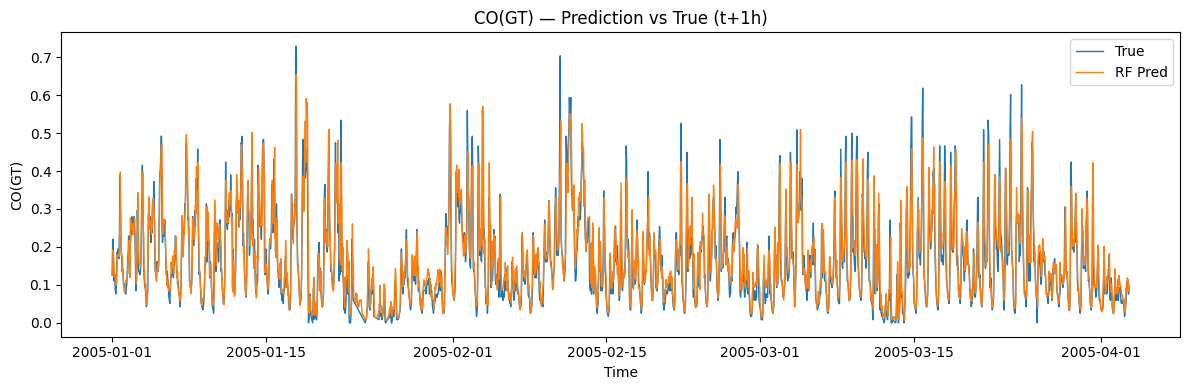

Saved plot: results/regression/plots/CO_GT_pred_vs_true_h1.png


In [ ]:
# Example plot for CO at t+1h
pol = 'CO(GT)'; h = 1
X_te, y_te = prepare_xy(test_df, pol, h)
if X_te is not None and len(X_te) > 0:
    model = RandomForestRegressor(**rf_params)
    X_tr, y_tr = prepare_xy(train_df, pol, h)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    dt = test_df.loc[X_te.index, 'DateTime']

    plt.figure(figsize=(12,4))
    plt.plot(dt, y_te.values, label='True', lw=1)
    plt.plot(dt, y_pred, label='RF Pred', lw=1)
    plt.title(f'{pol} — Prediction vs True (t+{h}h)')
    plt.xlabel('Time'); plt.ylabel(pol)
    plt.legend(); plt.tight_layout()
    out_png = PLOTS_DIR / f'{pol.replace("(", "_").replace(")","")}_pred_vs_true_h{h}.png'
    plt.savefig(out_png, dpi=150)
    plt.show()
    print(f"Saved plot: {out_png}")
else:
    print("No test data available for plotting.")

# Feature Importances (per pollutant & horizon)
importances_records = []  # Uses RandomForestRegressor already imported at top

for h in HORIZONS:
    # Collect pollutants modeled at this horizon
    modeled = [r['pollutant'] for r in results if r['horizon_h'] == h]
    for pol in modeled:
        X_tr, y_tr = prepare_xy(train_df, pol, h)
        if X_tr is None or len(X_tr) == 0:
            continue
        rf_tmp = RandomForestRegressor(**rf_params)
        rf_tmp.fit(X_tr, y_tr)
        for feat, val in zip(X_tr.columns, rf_tmp.feature_importances_):
            importances_records.append({'pollutant': pol, 'horizon_h': h, 'feature': feat, 'importance': float(val)})

fi_df = pd.DataFrame(importances_records)
fi_out = RESULTS_DIR / 'random_forest_feature_importances.csv'
fi_df.to_csv(fi_out, index=False)
print('Saved feature importances:', fi_out)
fi_df.head()